In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/sample-images'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# GradCAM, Model Interpretability - VGG16 & Xception Networks

### Objective

The objective of this post is to understand the importance of "Visual Explanations" for CNN based large scale Deep Neural Network Models.  
I will be proud if one feels, this post is nothing but a commentary on **R.R Selvaraju et al** paper in **IEEE ICCV, 2017** title [Grad-CAM: Visual Explanations from Deep Networks via Gradient-Based Localization](https://ieeexplore.ieee.org/document/8237336)

### Is this topic relevant to SIIM-ISIC Melanoma Detection?  
Yes, Its is. If you feel the same, please make me aware - We are in same page.

### Notebook Organization  
**PART 1: GradCAM Theory**    
- Problem Statement
- Seeing is Believing
- Grad-CAM Rationale
- The Approach
- The Algorithm - Math Involved
    - Gradient calculation via Backpropagation
    - Global Average Pooled Gradients
    - ReLU activation on Weights

**PART 2: Demo using Keras & Tensorflow**    
**Section 1**.  
- VGG16 and Xception Network Properties
- Image Preprocessing
- Step by Step Implementation of Heatmap Calculation
- Superimposition of Heatmap on Original Image

**Section 2**.  
- Exploration of Top - 9 Predictions and their Heatmap

**Section 3**.  
- Compute GradCAM heatmaps for predefined classes on an image.

# GradCAM Theory

## The Problem.  
Significant breakthroughs are achieved in computer vision during the past decade or so using Deep Neural Networks based on Convolutional Neural Network architecture. Following are some of the key areas where CNN based models drew extraordinary results,
1. Image Classification
2. Object Detection
3. Semantic Segmentation
4. Image Captioning 
5. Visual Question Answering 
6. Visual Dialog and 
7. Embodied Question Answering  

Though the performance of them are great and intuitive, they fail when it comes to model explanation and interpretability. 
- There is always a trade-off between accuracy and interpretability
- Lack of decomposability result in lack of explainable/interpretable models
- High complexity make interpretability hard. For e.g 200+ layer depth models like ResNets 
- Explainable models are usually lack accuracy scores 

However by making a model explainable and interpretable trust and faith on the model naturally increases exponentially.

### GradCAM Architecture
Image Ref: [http://gradcam.cloudcv.org/](http://gradcam.cloudcv.org/)

In [4]:
import tensorflow as tf
from tensorflow import keras
import cv2
import json

from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

FILE_PATH = ""

In [2]:
display(Image('http://gradcam.cloudcv.org/static/images/network.png'))

## Seeing is Believing.    
Building a model that have the ability to explain why they predict what they predict results in transparency and trustworthiness. This is achieved by
- Highlighting important pixels of predictios 
- Visualizing partial derivatives of predicted scores wrt pixel intensities
- Deconvolution by making modifications to raw gradients 
- Methods that sythesize images to maximally activate a network unit
- Invert a latent representation

The above all has good visual explainability. However they are not class discriminative. They tend to result in visualizations wrt different classes are nearly identical and lack finesse

Then what are the criteria for a good visual explanation.  
- Class Discriminative - i.e. localize the category in the image
- High Resolution - i.e. Capture fine-grained detail

## Why Grad-CAM?  
Gradient-weighted Class Activation Mapping(GradCAM) techniques comes with comprehensive answers for all above challenges. 
- They are class-discriminative using localization techniques
- They generate comprehendable visual explantaion for most of the CNN models
- They work without changing the architecture of the model
- They do not seek retraining the model
- They can be applied to widely acclaimed models lik ResNets, Xception, Inception etc with minimum effort
- They perform well with CNN+LSTM or Text Explanationable networks

## The Approach  
- Single shot localization through single forward and a partial backward pass per image
- Convolutional layers naturally retail spatial information that is lost in fully connected layers
- Last Conv layers to have the best compromize between high level semantics and detailed spatial info
- Neurons here look for semantic class specific info in the image
- GradCAM uses gradient information flow into the last conv layer to assign importance values to each neurons for a class of interest
- This can be applied for any layer of a DNN

## The Algorithm.  
The neurons in the last convolution layers concentrate on semantic class specific info of the input image. That is object/class specific parts of the whole image through segmentation. GradCAM fetches the gradient information flowing and assign importance values to each neurons.

### Gradient via Backpropagation
Let us call,  
The class discriminative localization map is $L_{GradCAM}^c \in \ R ^{u \times v}$

Where,  
$L$ is the GradCAM for a particular class $c$  
$u$ and $v$ are the width and height of the class $c$  

Further,  
$y_c$ is the gradient score for the class $c$ before softmax classification  
Gradient score is wrt $A^k$ the feature map activations of the last convolution layer. ie

$$y_c = \frac{\partial{y^c}}{\partial{A^k}}\tag{1. Gradients via Backpropagation}$$

### Global Average Pooling on Activation Maps
Usually the gradients $y_c$ flown back are Globally Average pooled over width and height but vary wrt architecture. Ref profperties of VGG16 and Xception. 

$$Weights_{NeuronImportance} = \alpha^c_k = \frac{1}{Z} \sum_{i=1}^u \sum_{i=1}^{v} y_c \tag{Global Average Pooled Gradients}$$
$$i.e.$$
$$\alpha^c_k = \frac{1}{Z} \sum_{i=1}^u \sum_{i=1}^{v} \frac{\partial{y^c}}{\partial{A^k}} \tag{2}$$

### GradCAM Activation Maps
- The weights calculated represents the partial linearization of the DNN downstream
- It captures the importance feature map $k$ for the target class $c$

Perform ReLU on the weighted combination of forward activation maps

$$L_{GradCAM}^c = ReLU(\,\sum_{i=1}^{k}\alpha^c_k) \,$$
- This operation results in coarse heatmap of the same size as the convolution feature maps (VGG16 $(14 \times 14)$, Xception $(10 \times 10)$)
- a ReLU is applied because, only the positive influence on the class of interest is considered
- i.e Negative influence are likedly to belong to other categories in the image
- Note: $y_c$ need not be the class score produced by an image classification, it could be any differentiable activation including words from a caption or answer to a question, in machine translation problems.

# Demo using Keras & Tensorflow

### VGG16 and Xception Properties

We shall demonstrate GradCAM approach on 2 widely accepted CNN Networks VGG16 and Xception. Following are the properties and one could extend this to other networks...

**VGG16**  
- Input Image Size is (224, 224)
- Last Convolution Layer Name:  block5_conv3
- Last Classifier Layers after Conv Layers: 5
- Heatmap Dimension: (14, 14)  

Ref Image: [Research Gate, Max Fergusan](https://www.researchgate.net/figure/Fig-A1-The-standard-VGG-16-network-architecture-as-proposed-in-32-Note-that-only_fig3_322512435)

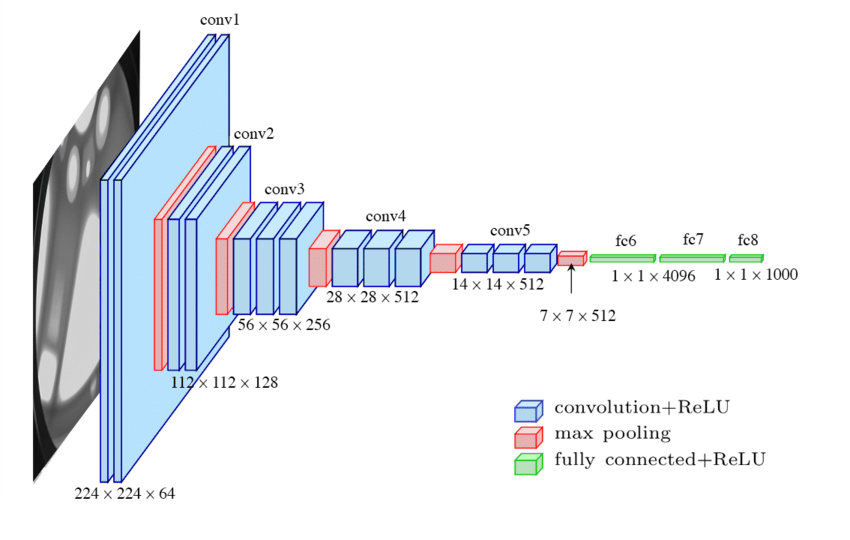

In [3]:
display(Image("https://www.researchgate.net/profile/Max_Ferguson/publication/322512435/figure/fig3/AS:697390994567179@1543282378794/Fig-A1-The-standard-VGG-16-network-architecture-as-proposed-in-32-Note-that-only.png"))

**Xception**  
- Input Image Size is (299, 299)
- Last Convolution Layer Name:  block14_sepconv2_act
- Last Classifier Layers after Conv Layers: 2
- Heatmap Dimension: (10, 10)

Ref Image: [Review of Xception by Sik-Ho Tsang](https://towardsdatascience.com/review-xception-with-depthwise-separable-convolution-better-than-inception-v3-image-dc967dd42568)

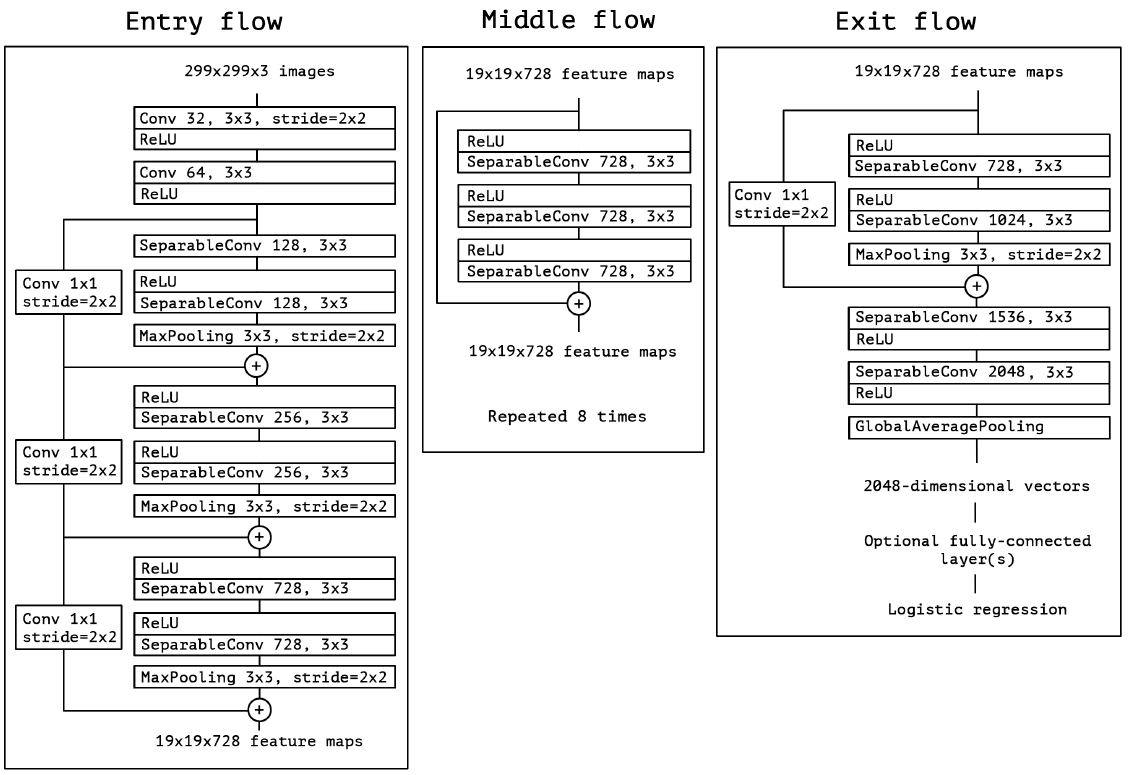

In [5]:
display(Image(FILE_PATH+"xception.png"))

In [ ]:
properties = {
    "vgg16": {
        "img_size": (224, 224),
        "last_conv_layer": "block5_conv3",
        "last_classifier_layers": [
            "block5_pool",
            "flatten",
            "fc1",
            "fc2",
            "predictions",
        ],
        "model_builder": keras.applications.vgg16.VGG16,
        "preprocess_input": keras.applications.vgg16.preprocess_input,
        "decode_predictions": keras.applications.vgg16.decode_predictions,
    },
    "xception": {
        "img_size": (299, 299),
        "last_conv_layer": "block14_sepconv2_act",
        "last_classifier_layers": [
            "avg_pool",
            "predictions",
        ],
        "model_builder": keras.applications.xception.Xception,
        "preprocess_input": keras.applications.xception.preprocess_input,
        "decode_predictions": keras.applications.xception.decode_predictions,
        
    }
}

Select the choice of your network and image, here I have taken boat_2.jpg. Also set how many top predictions we want to interospect

In [ ]:
NETWORK = "vgg16"
IMG_PATH = FILE_PATH + "pier.jpg"
IMG_2_PATH = FILE_PATH + "dock.jpg"
IMG_SIZE = properties[NETWORK]["img_size"]
LAST_CONV_LAYER = properties[NETWORK]["last_conv_layer"]
CLASSIFIER_LAYER_NAMES = properties[NETWORK]["last_classifier_layers"]

TOP_N = 8

Pick the corresponding model, image preprocessor and prediction decoder

In [ ]:
model_builder = properties[NETWORK]["model_builder"]
preprocess_input = properties[NETWORK]["preprocess_input"]
decode_predictions = properties[NETWORK]["decode_predictions"]

In [ ]:
display(Image(IMG_PATH))

## Preprocessing

In [ ]:
def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def load_imagenet_classes(filepath=FILE_PATH + "imagenet_1000_idx.js"):
    
    with open(filepath, 'r') as file:
        class_dict = json.loads(file.read())
    dict_by_name = {class_dict[key].split(",")[0]: int(key) for key in class_dict}
    return dict_by_name, class_dict

DICT_BY_NAME, CLASS_DICT = load_imagenet_classes()

Interospect the Predictions of the Input Image  
- Preprocess the Image, image to array conversion
- Get the Keras Model
- Predict the Image
- Decode the predictions 

In [ ]:
def get_predictions(image_path, image_size, top_n):
    img_array = get_img_array(image_path, size=image_size)
    img_array = preprocess_input(img_array)
    model = model_builder(weights="imagenet")
    preds = model.predict(img_array)
    preds_n = decode_predictions(preds, top=top_n)[0]
    return preds_n

preds_n = get_predictions(IMG_PATH, IMG_SIZE, TOP_N)

In [ ]:
def print_predictions(predictions):
    print("Predictions")
    for index in np.arange(len(predictions)):
        print(f'Id: {DICT_BY_NAME[predictions[index][1]]} Probability: {predictions[index][2]:4f} Class Name: {predictions[index][1].capitalize()}')
print_predictions(preds_n)

## Make GradCAM Heatmap  
Following method works in 2 modes  
1. Calculate GradCAM heatmaps for top N predictions, provided top_n > 0
2. Provide Imagenet index of the classes of interest and get gradient heatmap for the input image.

### STEPS
1. Create a model that maps the input image to the activations of the last convolution layer - Get last conv layer's output dimensions
2. Create another model, that maps from last convolution layer to the final class predictions - This is the classifier model that calculated the gradient
3. If top N predictions are to be interospected, Get their Imagenet indices else assign the indices given
4. Create an array to store the heatmaps
5. Iteratively calculate heatmaps for all classes of interest using GradientTape
6. Watch the last convolution output during the prediction process to calculate the gradients
7. Compute the activations of last conv layer and make the tape to watch
8. Get the class predictions and the class channel using the class index
9. Using tape, Get the gradient for the predicted class wrt the output feature map of last conv layer
10. Calculate the mean intensity of the gradient over its feature map channel
11. Multiply each channel in feature map array by weight importance of the channel
12. The channel-wise mean of the resulting feature map is our heatmap of class activation
13. Normalize the heatmap between [0, 1] for ease of visualization

In [ ]:
def get_top_predicted_indices(predictions, top_n):
    return np.argsort(-predictions).squeeze()[:top_n]

def make_gradcam_heatmap(
    img_array, model, 
    last_conv_layer_name, 
    classifier_layer_names,
    top_n,
    class_indices
):
    #1. Create a model that maps the input image to the activations of the last convolution layer - Get last conv layer's output dimensions
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)
    
    #2. Create another model, that maps from last convolution layer to the final class predictions - This is the classifier model that calculated the gradient
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)
    
    #3. If top N predictions are to be interospected, Get their Imagenet indices else assign the indices given
    if(top_n > 0):
        last_conv_layer_output = last_conv_layer_model(img_array)
        preds = classifier_model(last_conv_layer_output)
        class_indices = get_top_predicted_indices(preds, top_n)
    else:
        top_n = len(class_indices)
    
    #4. Create an array to store the heatmaps
    heatmaps = []
    #5. Iteratively calculate heatmaps for all classes of interest using GradientTape
    for index in np.arange(top_n):
    
        #6. Watch the last convolution output during the prediction process to calculate the gradients
        #7. Compute the activations of last conv layer and make the tape to watch
        with tf.GradientTape() as tape:
            # Compute activations of the last conv layer and make the tape watch it
            last_conv_layer_output = last_conv_layer_model(img_array)
            tape.watch(last_conv_layer_output)

            #8. Get the class predictions and the class channel using the class index
            preds = classifier_model(last_conv_layer_output)
            class_channel = preds[:, class_indices[index]]
            
        #9. Using tape, Get the gradient for the predicted class wrt the output feature map of last conv layer    
        grads = tape.gradient(
            class_channel,
            last_conv_layer_output
        )
        
        #10. Calculate the mean intensity of the gradient over its feature map channel
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))    
        last_conv_layer_output = last_conv_layer_output.numpy()[0]
        pooled_grads = pooled_grads.numpy()
        
        #11. Multiply each channel in feature map array by weight importance of the channel
        for i in range(pooled_grads.shape[-1]):
            last_conv_layer_output[:, :, i] *= pooled_grads[i]

        #12. The channel-wise mean of the resulting feature map is our heatmap of class activation
        heatmap = np.mean(last_conv_layer_output, axis=-1)

        #13. Normalize the heatmap between [0, 1] for ease of visualization
        heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

        heatmaps.append({
            "class_id": class_indices[index],
            "heatmap": heatmap
        })

    return heatmaps

## Exploration of Top N predictions

In [ ]:
# Calculate Heatmaps for TOP_N Predictions
heatmaps = make_gradcam_heatmap(
    get_img_array(IMG_PATH, IMG_SIZE), 
    model_builder(weights="imagenet"), 
    LAST_CONV_LAYER, 
    CLASSIFIER_LAYER_NAMES, 
    TOP_N, 
    None
)

In [ ]:
def superimpose_heatmap(image_path, heatmap):
    img = keras.preprocessing.image.load_img(image_path)
    img = keras.preprocessing.image.img_to_array(img)
    
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = keras.preprocessing.image.array_to_img(heatmap)
    heatmap = heatmap.resize((img.shape[1], img.shape[0]))
    
    heatmap = keras.preprocessing.image.img_to_array(heatmap)
    superimposed_img = cv2.addWeighted(heatmap, 0.4, img, 0.6, 0)
    
    return superimposed_img

In [ ]:
def display_superimposed_heatmaps(heatmaps, image_path):
    for index in np.arange(len(heatmaps)):
        heatmap = heatmaps[index]["heatmap"]
        class_id = heatmaps[index]["class_id"]
        print(f'Id: {class_id} Class: {CLASS_DICT[str(class_id)].split(",")[0].capitalize()}')
        superimposed_image = superimpose_heatmap(image_path, heatmap)
        save_path = "superimposed_image.jpg"
        cv2.imwrite(save_path, superimposed_image)
        display(Image(save_path))
        
display_superimposed_heatmaps(heatmaps, IMG_PATH)

## GradCAM for Classes of Interest  
- For a predefined set of 6 classes we shall see the GradCAM efficacy
- An image is carefully selected to view these predictions

In [ ]:

display(Image(IMG_2_PATH))

In [ ]:
#Classes of Interest
class_names = ('dock', 'pier', 'suspension_bridge', 'gondola', 'breakwater', 'dam')
class_indices = np.array([536, 718, 839, 576, 460, 525])

classes = [(class_indices[index], value) for index, value in enumerate(class_names)]
classes

In [ ]:
# Calculate Heatmaps for TOP_N Predictions
heatmaps = make_gradcam_heatmap(
    get_img_array(IMG_2_PATH, IMG_SIZE), 
    model_builder(weights="imagenet"), 
    LAST_CONV_LAYER, 
    CLASSIFIER_LAYER_NAMES, 
    0, 
    class_indices
)
display_superimposed_heatmaps(heatmaps, IMG_2_PATH)

### Reference
Arxiv Paper Link: [https://arxiv.org/abs/1610.02391](https://arxiv.org/abs/1610.02391)  
<cite>
@INPROCEEDINGS{8237336,  author={R. R. {Selvaraju} and M. {Cogswell} and A. {Das} and R. {Vedantam} and D. {Parikh} and D. {Batra}},  booktitle={2017 IEEE International Conference on Computer Vision (ICCV)},   title={Grad-CAM: Visual Explanations from Deep Networks via Gradient-Based Localization},   year={2017},  volume={},  number={},  pages={618-626},}
</cite>